In [1]:
# Load in our libraries
import pandas as pd
import numpy as np
import re
import sklearn
import xgboost as xgb
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV
from collections import Counter
import warnings
warnings.filterwarnings('ignore')

# Going to use these 5 base models for the stacking
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, ExtraTreesClassifier
from sklearn.svm import SVC

/home/csc/anaconda2/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
# Load in the train and test datasets
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

# Store our passenger ID for easy access
PassengerId = test['PassengerId']

In [3]:
train.head(3)

PassengerId  Survived  Pclass  \
0            1         0       3   
1            2         1       1   
2            3         1       3   

                                                Name     Sex   Age  SibSp  \
0                            Braund, Mr. Owen Harris    male  22.0      1   
1  Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0      1   
2                             Heikkinen, Miss. Laina  female  26.0      0   

   Parch            Ticket     Fare Cabin Embarked  
0      0         A/5 21171   7.2500   NaN        S  
1      0          PC 17599  71.2833   C85        C  
2      0  STON/O2. 3101282   7.9250   NaN        S

In [4]:
# Outlier detection 

def detect_outliers(df,n,features):
    """
    Takes a dataframe df of features and returns a list of the indices
    corresponding to the observations containing more than n outliers according
    to the Tukey method.
    """
    outlier_indices = []
    
    # iterate over features(columns)
    for col in features:
        # 1st quartile (25%)
        Q1 = np.percentile(df[col], 25)
        # 3rd quartile (75%)
        Q3 = np.percentile(df[col],75)
        # Interquartile range (IQR)
        IQR = Q3 - Q1
        
        # outlier step
        outlier_step = 1.5 * IQR
        
        # Determine a list of indices of outliers for feature col
        outlier_list_col = df[(df[col] < Q1 - outlier_step) | (df[col] > Q3 + outlier_step )].index
        # append the found outlier indices for col to the list of outlier indices 
        outlier_indices.extend(outlier_list_col)
        
    # select observations containing more than 2 outliers
    outlier_indices = Counter(outlier_indices) 
    #print outlier_indices
    multiple_outliers = list( k for k, v in outlier_indices.items() if v > n )
    
    return multiple_outliers   

# detect outliers from Age, SibSp , Parch and Fare
Outliers_to_drop = detect_outliers(train,2,["Age","SibSp","Parch","Fare"])
train.loc[Outliers_to_drop] # Show the outliers rows

PassengerId  Survived  Pclass                               Name     Sex  \
27            28         0       1     Fortune, Mr. Charles Alexander    male   
88            89         1       1         Fortune, Miss. Mabel Helen  female   
159          160         0       3         Sage, Master. Thomas Henry    male   
180          181         0       3       Sage, Miss. Constance Gladys  female   
201          202         0       3                Sage, Mr. Frederick    male   
792          793         0       3            Sage, Miss. Stella Anna  female   
324          325         0       3           Sage, Mr. George John Jr    male   
846          847         0       3           Sage, Mr. Douglas Bullen    male   
341          342         1       1     Fortune, Miss. Alice Elizabeth  female   
863          864         0       3  Sage, Miss. Dorothy Edith "Dolly"  female   

      Age  SibSp  Parch    Ticket    Fare        Cabin Embarked  
27   19.0      3      2     19950  263.00  C23 C25 C27        S  
88   23.0      3      2     19950  263.00  C23 C25 C27        S  
159   NaN      8      2  CA. 2343   69.55          NaN        S  
180   NaN      8      2  CA. 2343   69.55          NaN        S  
201   NaN      8      2  CA. 2343   69.55          NaN        S  
792   NaN      8      2  CA. 2343   69.55          NaN        S  
324   NaN      8      2  CA. 2343   69.55          NaN        S  
846   NaN      8      2  CA. 2343   69.55          NaN        S  
341  24.0      3      2     19950  263.00  C23 C25 C27        S  
863   NaN      8      2  CA. 2343   69.55          NaN        S

In [5]:
train = train.drop(Outliers_to_drop, axis = 0).reset_index(drop=True)

In [6]:
train_len = len(train)
dataset =  pd.concat(objs=[train, test], axis=0).reset_index(drop=True)

In [7]:
# Fill empty and NaNs values with NaN
dataset = dataset.fillna(np.nan)

# Check for Null values
dataset.isnull().sum()

Age             256
Cabin          1007
Embarked          2
Fare              1
Name              0
Parch             0
PassengerId       0
Pclass            0
Sex               0
SibSp             0
Survived        418
Ticket            0
dtype: int64

In [9]:
train.describe()

PassengerId    Survived      Pclass         Age       SibSp  \
count   881.000000  881.000000  881.000000  711.000000  881.000000   
mean    446.713961    0.385925    2.307605   29.731603    0.455165   
std     256.617021    0.487090    0.835055   14.547835    0.871571   
min       1.000000    0.000000    1.000000    0.420000    0.000000   
25%     226.000000    0.000000    2.000000   20.250000    0.000000   
50%     448.000000    0.000000    3.000000   28.000000    0.000000   
75%     668.000000    1.000000    3.000000   38.000000    1.000000   
max     891.000000    1.000000    3.000000   80.000000    5.000000   

            Parch        Fare  
count  881.000000  881.000000  
mean     0.363224   31.121566  
std      0.791839   47.996249  
min      0.000000    0.000000  
25%      0.000000    7.895800  
50%      0.000000   14.454200  
75%      0.000000   30.500000  
max      6.000000  512.329200

In [10]:
train.describe(include=['O', 'category'])

Name   Sex Ticket Cabin Embarked
count                         881   881    881   201      879
unique                        881     2    680   147        3
top     Graham, Mr. George Edward  male   1601    G6        S
freq                            1   572      7     4      634

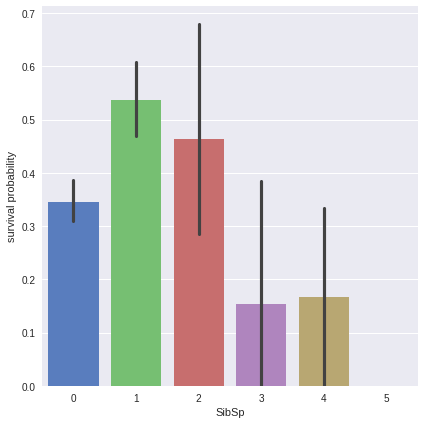

In [11]:
g = sns.factorplot(x="SibSp",y="Survived",data=train,kind="bar", size = 6 , 
palette = "muted")
g.despine(left=True)
g = g.set_ylabels("survival probability")

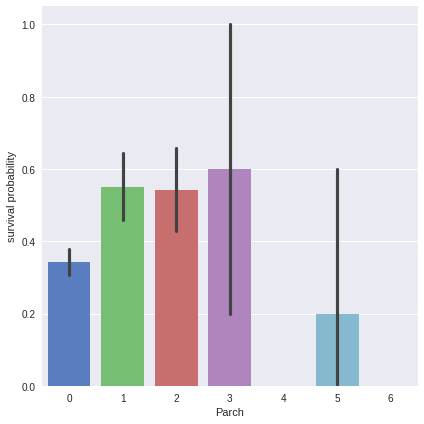

In [12]:
g  = sns.factorplot(x="Parch",y="Survived",data=train,kind="bar", size = 6 , 
palette = "muted")
g.despine(left=True)
g = g.set_ylabels("survival probability")

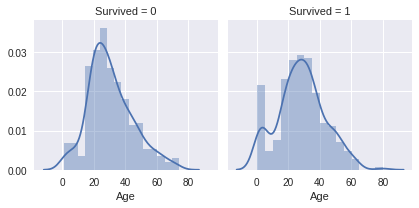

In [13]:
g = sns.FacetGrid(train, col='Survived')
g = g.map(sns.distplot, "Age")

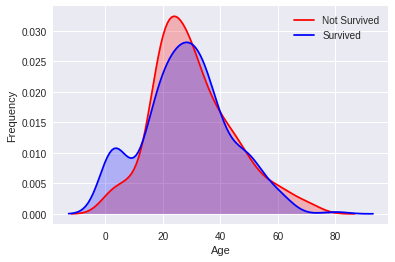

In [14]:
g = sns.kdeplot(train["Age"][(train["Survived"] == 0) & (train["Age"].notnull())], color="Red", shade = True)
g = sns.kdeplot(train["Age"][(train["Survived"] == 1) & (train["Age"].notnull())], ax =g, color="Blue", shade= True)
g.set_xlabel("Age")
g.set_ylabel("Frequency")
g = g.legend(["Not Survived","Survived"])

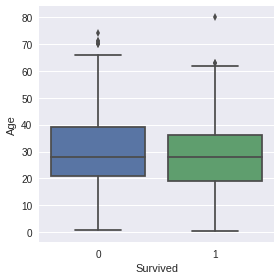

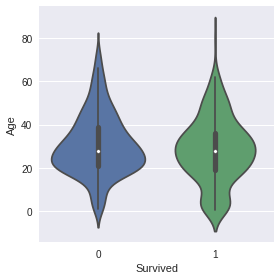

In [15]:
g = sns.factorplot(x="Survived", y = "Age",data = train, kind="box")
g = sns.factorplot(x="Survived", y = "Age",data = train, kind="violin")

In [16]:
dataset[dataset['Fare'].isnull()]

Age Cabin Embarked  Fare                Name  Parch  PassengerId  \
1033  60.5   NaN        S   NaN  Storey, Mr. Thomas      0         1044   

      Pclass   Sex  SibSp  Survived Ticket  
1033       3  male      0       NaN   3701

In [17]:
median = dataset[(dataset.Pclass==3)&(dataset.Embarked=='S')]['Fare'].median()
dataset["Fare"] = dataset["Fare"].fillna(median)

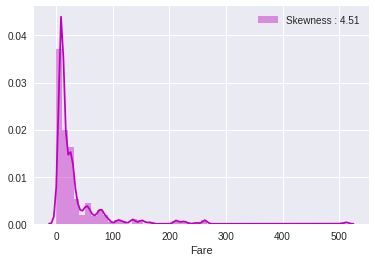

In [18]:
g = sns.distplot(dataset["Fare"], color="m", label="Skewness : %.2f"%(dataset["Fare"].skew()))
g = g.legend(loc="best")

In [19]:
dataset["Fare"] = dataset["Fare"].map(lambda i: np.log(i) if i > 0 else 0)

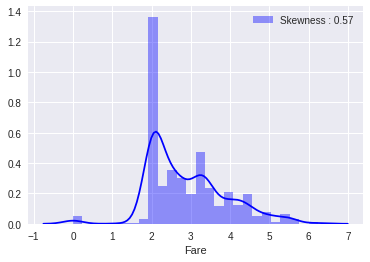

In [20]:
g = sns.distplot(dataset["Fare"], color="b", label="Skewness : %.2f"%(dataset["Fare"].skew()))
g = g.legend(loc="best")

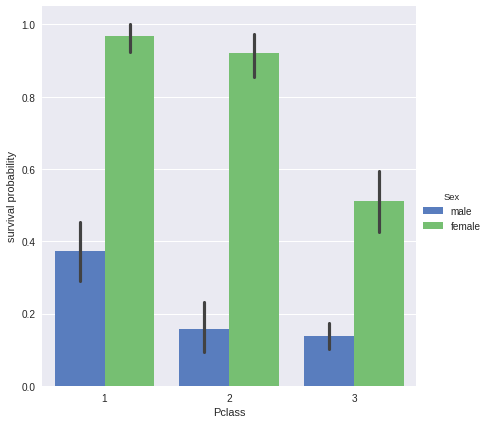

In [21]:
g = sns.factorplot(x="Pclass", y="Survived", hue="Sex", data=train,
                   size=6, kind="bar", palette="muted")
g.despine(left=True)
g = g.set_ylabels("survival probability")

      Age Cabin Embarked      Fare                                       Name  \
60   38.0   B28      NaN  4.382027                        Icard, Miss. Amelie   
821  62.0   B28      NaN  4.382027  Stone, Mrs. George Nelson (Martha Evelyn)   

     Parch  PassengerId  Pclass     Sex  SibSp  Survived  Ticket  
60       0           62       1  female      0       1.0  113572  
821      0          830       1  female      0       1.0  113572  


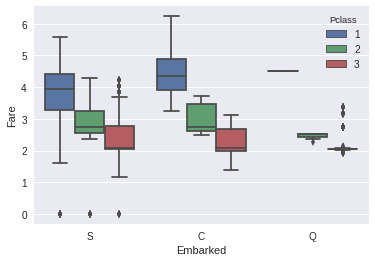

In [22]:
sns.boxplot(x="Embarked", y="Fare", hue="Pclass", data=dataset);
print dataset[dataset['Embarked'].isnull()]
dataset["Embarked"] = dataset["Embarked"].fillna('C')

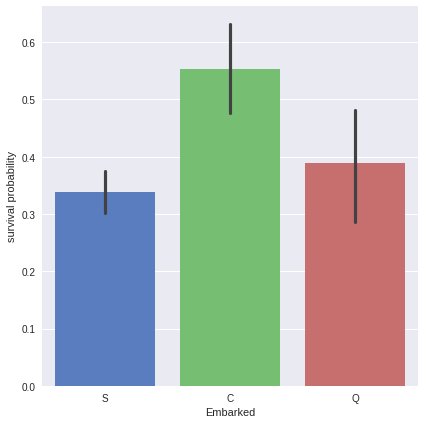

In [23]:
g = sns.factorplot(x="Embarked", y="Survived",  data=train,
                   size=6, kind="bar", palette="muted")
g.despine(left=True)
g = g.set_ylabels("survival probability")

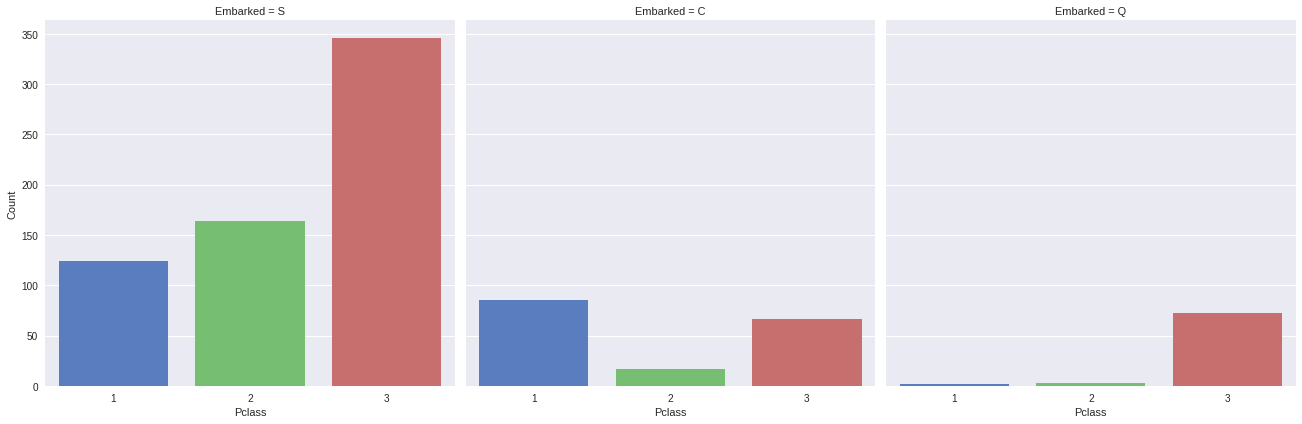

In [24]:
g = sns.factorplot("Pclass", col="Embarked",  data=train,
                   size=6, kind="count", palette="muted")
g.despine(left=True)
g = g.set_ylabels("Count")

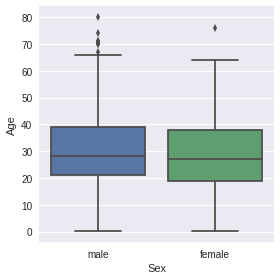

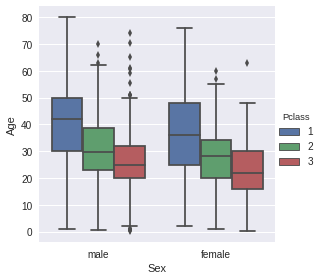

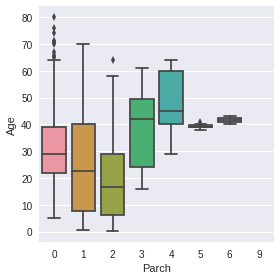

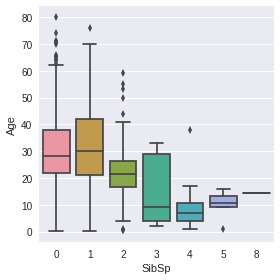

In [25]:
g = sns.factorplot(y="Age",x="Sex",data=dataset,kind="box")
#Age distribution seems to be the same in Male and Female subpopulations, 
#so Sex is not informative to predict Age.
g = sns.factorplot(y="Age",x="Sex",hue="Pclass", data=dataset,kind="box")
g = sns.factorplot(y="Age",x="Parch", data=dataset,kind="box")
g = sns.factorplot(y="Age",x="SibSp", data=dataset,kind="box")

In [26]:
dataset["Sex"] = dataset["Sex"].map({"male": 0, "female":1})

In [27]:
index_NaN_age = list(dataset["Age"][dataset["Age"].isnull()].index)

for i in index_NaN_age :
    age_med = dataset["Age"].median()
    age_pred = dataset["Age"][((dataset['SibSp'] == dataset.iloc[i]["SibSp"]) & (dataset['Parch'] == dataset.iloc[i]["Parch"]) & (dataset['Pclass'] == dataset.iloc[i]["Pclass"]))].median()
    if not np.isnan(age_pred) :
        dataset['Age'].iloc[i] = age_pred
    else :
        dataset['Age'].iloc[i] = age_med

In [28]:
dataset["Name"].head()

0                              Braund, Mr. Owen Harris
1    Cumings, Mrs. John Bradley (Florence Briggs Th...
2                               Heikkinen, Miss. Laina
3         Futrelle, Mrs. Jacques Heath (Lily May Peel)
4                             Allen, Mr. William Henry
Name: Name, dtype: object

In [29]:
# Get Title from Name
dataset_title = [i.split(",")[1].split(".")[0].strip() for i in dataset["Name"]]
dataset["Title"] = pd.Series(dataset_title)
dataset["Title"].head()

0      Mr
1     Mrs
2    Miss
3     Mrs
4      Mr
Name: Title, dtype: object

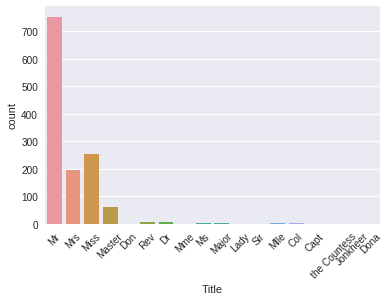

In [30]:
g = sns.countplot(x="Title",data=dataset)
g = plt.setp(g.get_xticklabels(), rotation=45) 

In [31]:
# Convert to categorical values Title 
dataset["Title"] = dataset["Title"].replace(['Lady', 'the Countess','Countess','Capt', 'Col','Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')
dataset["Title"] = dataset["Title"].map({"Master":1, "Miss":0, "Ms" : 0 , "Mme":0, "Mlle":0, "Mrs":0, "Mr":3, "Rare":2})
dataset["Title"] = dataset["Title"].astype(int)

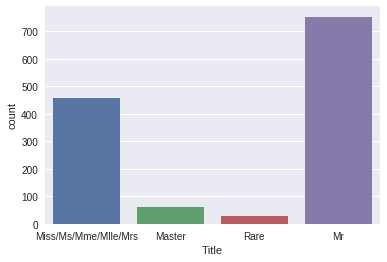

In [32]:
g = sns.countplot(dataset["Title"])
g = g.set_xticklabels(["Miss/Ms/Mme/Mlle/Mrs","Master",'Rare',"Mr"])

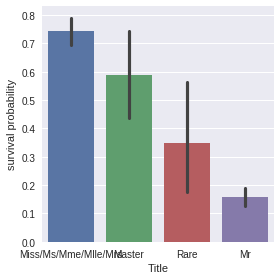

In [33]:
g = sns.factorplot(x="Title",y="Survived",data=dataset,kind="bar")
g = g.set_xticklabels(["Miss/Ms/Mme/Mlle/Mrs","Master",'Rare',"Mr"])
g = g.set_ylabels("survival probability")

[1 3 0 2]


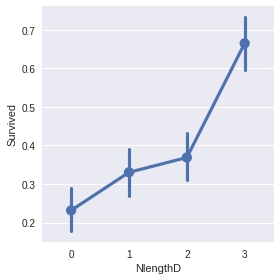

In [34]:
dataset['Name_length'] = dataset['Name'].apply(len)
dataset['NlengthD'] = pd.qcut(dataset['Name_length'], 4, labels=[0,1,2,3]).astype(int)
sns.factorplot(x="NlengthD", y="Survived", data=dataset,order=[0,1,2,3])
print(dataset["NlengthD"].unique())

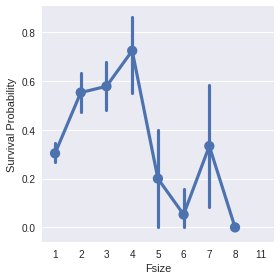

In [35]:
dataset["Fsize"] = dataset["SibSp"] + dataset["Parch"] + 1
g = sns.factorplot(x="Fsize",y="Survived",data = dataset)
g = g.set_ylabels("Survival Probability")

In [36]:
dataset['Single'] = dataset['Fsize'].map(lambda s: 1 if s == 1 else 0)
dataset['SmallF'] = dataset['Fsize'].map(lambda s: 1 if  s == 2  else 0)
dataset['MedF'] = dataset['Fsize'].map(lambda s: 1 if 3 <= s <= 4 else 0)
dataset['LargeF'] = dataset['Fsize'].map(lambda s: 1 if s >= 5 else 0)

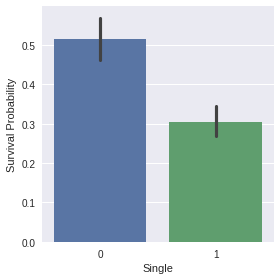

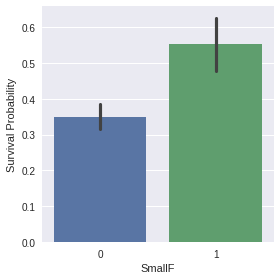

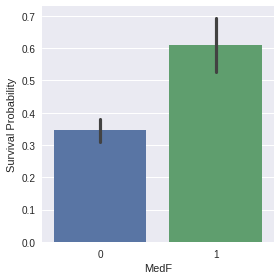

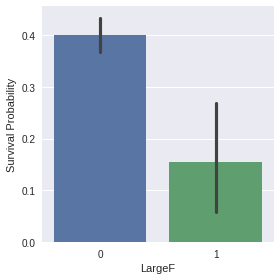

In [37]:
g = sns.factorplot(x="Single",y="Survived",data=dataset,kind="bar")
g = g.set_ylabels("Survival Probability")
g = sns.factorplot(x="SmallF",y="Survived",data=dataset,kind="bar")
g = g.set_ylabels("Survival Probability")
g = sns.factorplot(x="MedF",y="Survived",data=dataset,kind="bar")
g = g.set_ylabels("Survival Probability")
g = sns.factorplot(x="LargeF",y="Survived",data=dataset,kind="bar")
g = g.set_ylabels("Survival Probability")

In [38]:
dataset = pd.get_dummies(dataset, columns = ["Title"])
dataset = pd.get_dummies(dataset, columns = ["Embarked"], prefix="Em")

In [39]:
dataset["Cabin"].head()
dataset["Cabin"] = pd.Series([i[0] if not pd.isnull(i) else 'X' for i in dataset['Cabin'] ])

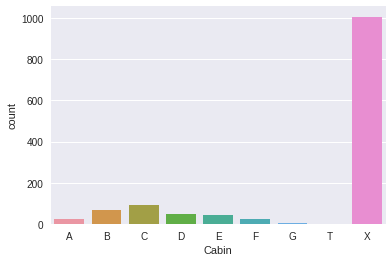

In [40]:
g = sns.countplot(dataset["Cabin"],order=['A','B','C','D','E','F','G','T','X'])

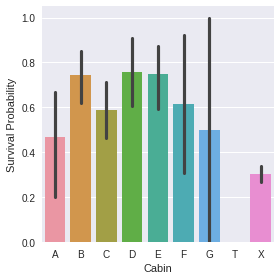

In [41]:
g = sns.factorplot(y="Survived",x="Cabin",data=dataset,kind="bar",order=['A','B','C','D','E','F','G','T','X'])
g = g.set_ylabels("Survival Probability")

In [42]:
dataset = pd.get_dummies(dataset, columns = ["Cabin"],prefix="Cabin")

In [43]:
dataset["Ticket"].head()

0           A/5 21171
1            PC 17599
2    STON/O2. 3101282
3              113803
4              373450
Name: Ticket, dtype: object

In [44]:
Ticket = []
for i in list(dataset.Ticket):
    if not i.isdigit() :
        Ticket.append(i.replace(".","").replace("/","").strip().split(' ')[0]) #Take prefix
    else:
        Ticket.append("X")
        
dataset["Ticket"] = Ticket
dataset["Ticket"].head()

0        A5
1        PC
2    STONO2
3         X
4         X
Name: Ticket, dtype: object

In [57]:
def get_child(age):
    return 1 if age.Age < 16 else 0
def get_old(age):
    return 1 if age.Age >= 70 else 0   
dataset['children'] = dataset[['Age']].apply(get_child,axis=1)
dataset['old']    = dataset[['Age']].apply(get_old,axis=1)

In [58]:
dataset = pd.get_dummies(dataset, columns = ["Ticket"], prefix="T")

In [59]:
dataset["Pclass"] = dataset["Pclass"].astype("category")
dataset = pd.get_dummies(dataset, columns = ["Pclass"],prefix="Pc")

In [60]:
dataset.drop(labels = ["PassengerId"], axis = 1, inplace = True)
dataset.drop(labels = ["Name"], axis = 1, inplace = True)

In [74]:
arr = ['Age','Fare']
dataset[arr] = dataset[arr].astype(int)
#dataset.loc[:,1:] = dataset[:,1:].astype(int)

In [80]:
dataset.index

RangeIndex(start=0, stop=1299, step=1)

In [93]:
dataset.head()

Age  Fare  Parch  Sex  SibSp  Survived  Name_length  NlengthD  Fsize  \
0   22     1      0    0      1       0.0           23         1      2   
1   38     4      0    1      1       1.0           51         3      2   
2   26     2      0    1      0       1.0           22         1      1   
3   35     3      0    1      1       1.0           44         3      2   
4   35     2      0    0      0       0.0           24         1      1   

   Single  ...   T_STONO  T_STONO2  T_STONOQ  T_SWPP  T_WC  T_WEP  T_X  Pc_1  \
0       0  ...         0         0         0       0     0      0    0     0   
1       0  ...         0         0         0       0     0      0    0     1   
2       1  ...         0         1         0       0     0      0    0     0   
3       0  ...         0         0         0       0     0      0    1     1   
4       1  ...         0         0         0       0     0      0    1     0   

   Pc_2  Pc_3  
0     0     1  
1     0     0  
2     0     1  
3     0     0  
4     0     1  

[5 rows x 71 columns]

In [154]:
# Create Numpy arrays of train, test and target ( Survived) dataframes to feed into our models
x_test = dataset[train_len:]
x_test.drop(labels=["Survived"],axis = 1,inplace=True)
dataset[:train_len]["Survived"] = dataset[:train_len]["Survived"].astype(int)

y_train = dataset[:train_len]["Survived"].values.astype(int)
x_train = dataset[:train_len].drop(labels = ["Survived"],axis = 1).values

print x_train.shape
print y_train.shape
print x_test.shape

(881, 70)
(881,)
(418, 70)


The best parameters are {'kernel': 'rbf', 'C': 31.622776601683793, 'gamma': 0.0023713737056616554} with a score of 0.83200908


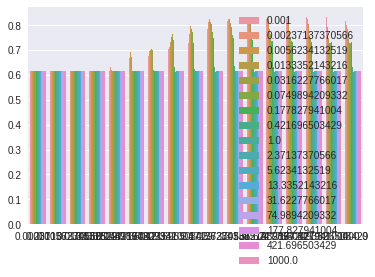

In [104]:
param_grid = dict(gamma=np.logspace(-3, 3, 17), C=np.logspace(-3, 3, 17),kernel=['rbf'])
cv = StratifiedKFold(n_splits=5,random_state=42)
gridsvc2 = GridSearchCV(SVC(), param_grid=param_grid, cv=cv,n_jobs=-1)
gridsvc2.fit(x_train, y_train)
print("The best parameters are %s with a score of %0.8f"% \
      (gridsvc2.best_params_, gridsvc2.best_score_))

#print gridsvc2.cv_results_['param_C']
#print gridsvc2.cv_results_['param_gamma']
#print gridsvc2.cv_results_['mean_test_score']
sns.barplot(x='param_C',y='mean_test_score',hue='param_gamma',data=gridsvc2.cv_results_)

In [107]:
parameter_grid = {
             'max_depth' : [4, 6, 8],
             'n_estimators': [700],
             'max_features' : ['sqrt', 'log2'],
             'min_samples_split': [2, 3, 10],
             'min_samples_leaf': [2, 3, 10],
             'bootstrap': [True, False],
             }

grid_search = GridSearchCV(RandomForestClassifier(),
                           scoring='accuracy',
                           param_grid=parameter_grid,n_jobs=-1,
                           cv=StratifiedKFold(n_splits=5,random_state=42))

grid_search.fit(x_train, y_train)
parameters = grid_search.best_params_

print('Best score: {}'.format(grid_search.best_score_))
print('Best parameters: {}'.format(grid_search.best_params_))

Best score: 0.827468785471
Best parameters: {'bootstrap': False, 'min_samples_leaf': 2, 'n_estimators': 700, 'min_samples_split': 2, 'max_features': 'sqrt', 'max_depth': 6}


In [ ]:
for i in range(5):
    print grid_search.cv_results_['split%d_test_score' % i]
grid_search.cv_results_['mean_test_score']

In [155]:
from sklearn.metrics import accuracy_score
SEED=42
def get_oof(clf, x_train, y_train, x_test):
    oof_train = np.zeros((x_train.shape[0],))
    skf = StratifiedKFold(n_splits=5,random_state=42)
    skf.get_n_splits(x_train,y_train)
    oof_test = np.zeros((x_test.shape[0],))

    for train_index, test_index in skf.split(x_train,y_train):
        x_tr = x_train[train_index]
        y_tr = y_train[train_index]
        x_te = x_train[test_index]
        clf.fit(x_tr, y_tr)
        oof_train[test_index] = clf.predict(x_te)
        oof_test += clf.predict(x_test)
        

    oof_test = oof_test / 5.0
    print accuracy_score(y_train,oof_train.reshape(-1))
    return oof_train.reshape(-1, 1), oof_test.reshape(-1, 1)

In [156]:
et_params = {
    'n_jobs': -1,
    'n_estimators':500,
    #'max_features': 0.5,
    'max_depth': 8,
    'min_samples_leaf': 2,
    'verbose': 0
}
et = ExtraTreesClassifier(**et_params)
et_oof_train, et_oof_test = get_oof(et,x_train,y_train,x_test)

0.825198637911


In [157]:
rf_params = {'bootstrap': False, 'min_samples_leaf': 2, 'n_estimators': 700, 
             'min_samples_split': 2, 'max_features': 'sqrt', 'max_depth': 6}
rf_params = {
    'n_jobs': -1,
    'n_estimators': 500,
     'warm_start': True, 
     #'max_features': 0.2,
    'max_depth': 6,
    'min_samples_leaf': 2,
    'max_features' : 'sqrt',
    'verbose': 0
}
rf = RandomForestClassifier(**rf_params)
rf_oof_train, rf_oof_test = get_oof(rf,x_train,y_train,x_test)

0.847900113507


In [158]:
ada_params = {
    'n_estimators': 1000,
    'learning_rate' : 0.05
}
ada = AdaBoostClassifier(**ada_params)
ada_oof_train, ada_oof_test = get_oof(ada,x_train,y_train,x_test)

0.817253121453


In [159]:
gb_params = {
    'n_estimators': 500,
     #'max_features': 0.2,
    'max_depth': 5,
    'min_samples_leaf': 2,
    'verbose': 0
}
gb = GradientBoostingClassifier(**gb_params)
gb_oof_train, gb_oof_test = get_oof(gb,x_train,y_train,x_test)

0.802497162316


In [160]:
svc_params = {'kernel': 'rbf', 'C': 31.622776601683793, 'gamma': 0.0023713737056616554}
svc_oof_train, svc_oof_test = get_oof(SVC(**svc_params),x_train,y_train,x_test)

0.83200908059


**Feature importances generated from the different classifiers**

Now having learned our the first-level classifiers, we can utilise a very nifty feature of the Sklearn models and that is to output the importances of the various features in the training and test sets with one very simple line of code.

As per the Sklearn documentation, most of the classifiers are built in with an attribute which returns feature importances by simply typing in **.feature_importances_**. Therefore we will invoke this very useful attribute via our function earliand plot the feature importances as such

In [142]:
rf_features = rf.feature_importances_
et_features = et.feature_importances_
ada_features = ada.feature_importances_
gb_features = gb.feature_importances_

So I have not yet figured out how to assign and store the feature importances outright. Therefore I'll print out the values from the code above and then simply copy and paste into Python lists as below (sorry for the lousy hack)

Create a dataframe from the lists containing the feature importance data for easy plotting via the Plotly package.

In [144]:
print gb_features
cols = dataset[:train_len].drop(labels = ["Survived"],axis = 1).columns.values
# Create a dataframe with features
feature_dataframe = pd.DataFrame( {'features': cols,
     'Random Forest feature importances': rf_features,
     'Extra Trees  feature importances': et_features,
      'AdaBoost feature importances': ada_features,
    'Gradient Boost feature importances': gb_features
    })

[  2.96387994e-01   4.01894731e-02   1.13592180e-02   6.50497136e-03
   1.80772811e-02   2.51361195e-01   2.13904546e-02   2.83067496e-02
   9.94430812e-03   1.45018891e-02   7.06900913e-03   4.04063803e-03
   5.53220881e-03   3.54178999e-03   2.95106648e-03   2.73771399e-02
   1.96190997e-02   1.54555056e-02   1.82444289e-02   2.52488058e-03
   3.48359172e-03   2.07927602e-02   4.01620685e-03   7.03073657e-03
   1.92012835e-03   3.65451824e-03   0.00000000e+00   7.33079222e-03
   1.87216873e-04   1.11751246e-04   0.00000000e+00   1.57618993e-03
   2.40538830e-02   0.00000000e+00   0.00000000e+00   0.00000000e+00
   4.53606239e-03   1.63929056e-03   0.00000000e+00   0.00000000e+00
   2.50517818e-04   0.00000000e+00   4.28873589e-03   0.00000000e+00
   7.87779668e-03   1.16121057e-03   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   3.39666957e-03   0.00000000e+00   1.72540638e-04   0.00000000e+00
   0.00000000e+00   0.00000000e+00

**Interactive feature importances via Plotly scatterplots**

I'll use the interactive Plotly package at this juncture to visualise the feature importances values of the different classifiers 

Now let us calculate the mean of all the feature importances and store it as a new column in the feature importance dataframe

In [145]:
# Create the new column containing the average of values

feature_dataframe['mean'] = feature_dataframe.mean(axis= 1) # axis = 1 computes the mean row-wise
feature_dataframe.head(3)

AdaBoost feature importances  Extra Trees  feature importances  \
0                         0.191                          0.013003   
1                         0.094                          0.022718   
2                         0.000                          0.008032   

   Gradient Boost feature importances  Random Forest feature importances  \
0                            0.296388                           0.045280   
1                            0.040189                           0.058606   
2                            0.011359                           0.013833   

  features      mean  
0      Age  0.136418  
1     Fare  0.053878  
2    Parch  0.008306

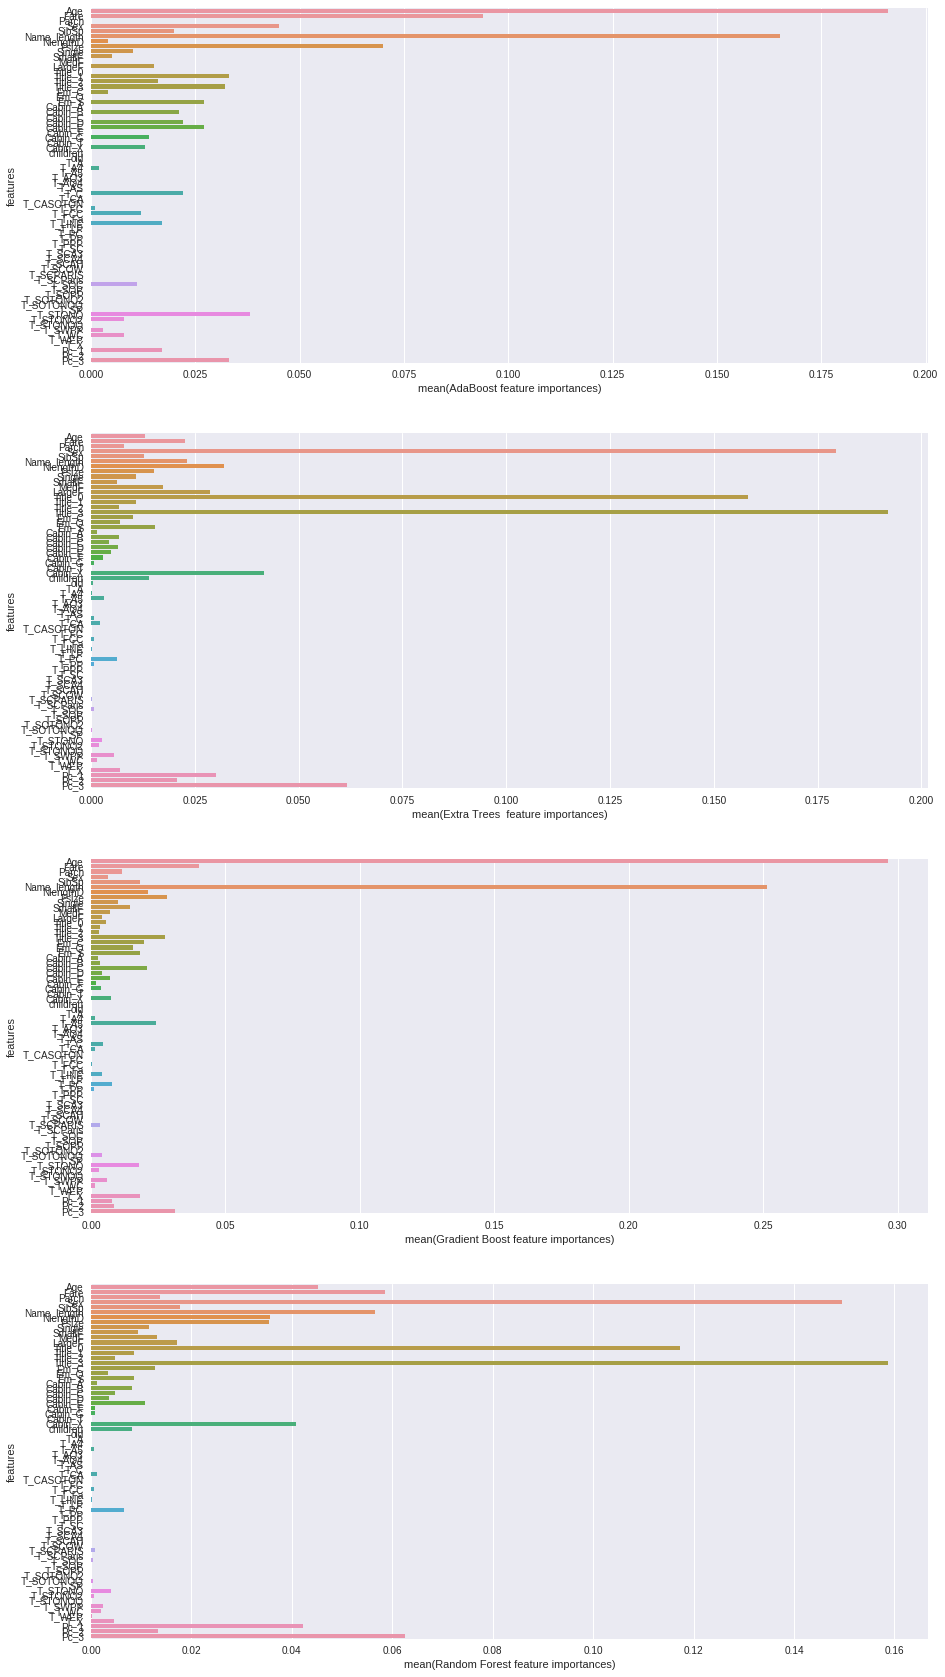

In [146]:
_,ax=plt.subplots(4,1,figsize=(15,30))
for i,classify in enumerate(feature_dataframe.columns.values[:4:]):
    sns.barplot(y='features',x=classify,data=feature_dataframe,ax=ax[i])

# Second-Level Predictions from the First-level Output

**First-level output as new features**

Having now obtained our first-level predictions, one can think of it as essentially building a new set of features to be used as training data for the next classifier. As per the code below, we are therefore having as our new columns the first-level predictions from our earlier classifiers and we train the next classifier on this.

In [147]:
base_predictions_train = pd.DataFrame( {'RandomForest': rf_oof_train.ravel(),
     'ExtraTrees': et_oof_train.ravel(),
     'AdaBoost': ada_oof_train.ravel(),
      'GradientBoost': gb_oof_train.ravel()
    })
base_predictions_train.head()

AdaBoost  ExtraTrees  GradientBoost  RandomForest
0       0.0         0.0            0.0           0.0
1       1.0         1.0            1.0           1.0
2       1.0         0.0            1.0           1.0
3       1.0         1.0            1.0           1.0
4       0.0         0.0            0.0           0.0

**Correlation Heatmap of the Second Level Training set**

There have been quite a few articles and Kaggle competition winner stories about the merits of having trained models that are more uncorrelated with one another producing better scores.

In [161]:
print et_oof_train.shape
x_train_stack = np.concatenate(( et_oof_train, rf_oof_train,gb_oof_train,ada_oof_train,svc_oof_train), axis=1)
x_test_stack = np.concatenate(( et_oof_test, rf_oof_test, gb_oof_test,ada_oof_test,svc_oof_test), axis=1)
print x_train_stack.shape
print x_test_stack.shape

(881, 1)
(881, 5)
(418, 5)


Having now concatenated and joined both the first-level train and test predictions as x_train and x_test, we can now fit a second-level learning model.

### Second level learning model via XGBoost

Here we choose the eXtremely famous library for boosted tree learning model, XGBoost. It was built to optimize large-scale boosted tree algorithms. For further information about the algorithm, check out the [official documentation][1].

  [1]: https://xgboost.readthedocs.io/en/latest/

Anyways, we call an XGBClassifier and fit it to the first-level train and target data and use the learned model to predict the test data as follows:

In [162]:
gbm = xgb.XGBClassifier(
 learning_rate = 0.02,
 n_estimators= 4000,
 max_depth= 4,
 min_child_weight= 2,
 #gamma=1,
 gamma=0.9,                        
 subsample=0.8,
 colsample_bytree=0.8,
 objective= 'binary:logistic',
 nthread= -1,
 scale_pos_weight=1).fit(x_train_stack, y_train)
print accuracy_score(gbm.predict(x_train_stack),y_train)
predictions = gbm.predict(x_test_stack)

0.851305334847


Just a quick run down of the XGBoost parameters used in the model:

**max_depth** : How deep you want to grow your tree. Beware if set to too high a number might run the risk of overfitting.

**gamma** : minimum loss reduction required to make a further partition on a leaf node of the tree. The larger, the more conservative the algorithm will be.

**eta** : step size shrinkage used in each boosting step to prevent overfitting

**Producing the Submission file**

Finally having trained and fit all our first-level and second-level models, we can now output the predictions into the proper format for submission to the Titanic competition as follows:

In [163]:
# Generate Submission File 
StackingSubmission = pd.DataFrame({ 'PassengerId': PassengerId,
                            'Survived': predictions })
StackingSubmission.to_csv("titanic.csv", index=False)

**Steps for Further Improvement**

As a closing remark it must be noted that the steps taken above just show a very simple way of producing an ensemble stacker. You hear of ensembles created at the highest level of Kaggle competitions which involves monstrous combinations of stacked classifiers as well as levels of stacking which go to more than 2 levels. 

Some additional steps that may be taken to improve one's score could be:

 1. Implementing a good cross-validation strategy in training the models to find optimal parameter values
 2. Introduce a greater variety of base models for learning. The more uncorrelated the results, the better the final score.